# DCGAN on Dogs
We apply DCGAN on the Dogs dataset. The original paper can be found [here](https://arxiv.org/pdf/1511.06434.pdf). The idea is that we do away with fully connected layers and have convolutional layers in both the networks. The only 2 conv layers will be the input layer at Generator and output layer at Discriminator. Apart from that there are several changes that we make which are as follows - 
+ LeakyReLU for both the networks except last layer
+ Batch Norm to ensure mode collapse doesnt happen
+ Instead of pooling, strided conv(discriminator) and fractional strided conv(generator)
Apart from that we also make several additions to improve the network which are as follows - 
+ [Spectral Normalization](https://christiancosgrove.com/blog/2018/01/04/spectral-normalization-explained.html) which helps in attaining stabilization. It is applied on convolutional layers and fixes a huge problem
+ [Pixel wise Normalization](https://medium.com/@EricKuy/progressive-gan-dd7cadb17dc4) an Idea from ProGans.
+ Mini Batch Std deviation
+ TTUR - basically different LR for generator and discriminator
+ Label Smoothning - Instead of 1, we use 0.9 for discriminator so that it generalizes better
+ Dropout Layer in Generator  
Read more about tips and tricks [here](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)  
Based on this [code](https://www.kaggle.com/purplejester/good-old-dcgan-with-simple-tricks-lb-58)

In [115]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import os
import numpy as np

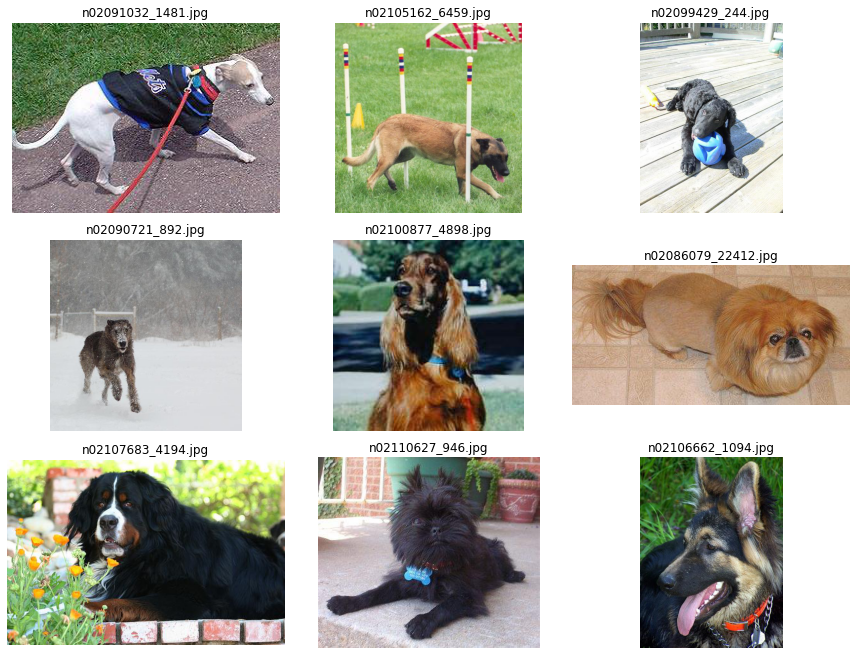

In [121]:
images = os.listdir('all-dogs/')
fig, axes = plt.subplots(3,3,figsize=(12,10))
for indx, axis in enumerate(axes.flatten()):
#     rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    img = plt.imread("all-dogs/"+images[indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [122]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

In [123]:
batch = 32
img_size = 64
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=5)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='all-dogs/',
                           transform1=transform1,
                           transform2=transform2)

In [124]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=batch, num_workers=4)
imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0,2,3,1)

In [125]:
class SpectralNorm(nn.Module):
    def __init__(self,module):
        super().__init__()
        self.module = nn.utils.spectral_norm(module)
    def forward(self,x):
        return self.module(x)
class PixelNorm(nn.Module):
    def __init__(self, alpha=1e-8):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        y = x.pow(2.).mean(dim=1, keepdim=True).add(self.alpha).sqrt()
        y = x / y
        return y
class MinibatchStdDev(nn.Module):
    def __init__(self,alpha=1e-8):
        super().__init__()
        self.alpha = alpha
        
    def forward(self,x):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = y.pow(2.).mean(dim=0, keepdim=False).add(self.alpha).sqrt()
        y = y.mean().view(1, 1, 1, 1)
        y = y.repeat(batch_size, 1, height, width)
        y = torch.cat([x, y], 1)
        return y

class Mixup:
    def __init__(self,alpha=0.2):
        self.alpha = alpha
    def __call__(self,b1,b2):
        assert b1.size(0) == b2.size(0)
        lam = np.random.beta(self.alpha,self.alpha,size=b1.size(0))
        lam = torch.from_numpy(lam).float().to(b1.device)
        lam = lam.view(-1,1,1,1)
        return lam*b1 + (1-lam)*b2

In [126]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [186]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.hidden0 = nn.Sequential(SpectralNorm(nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False)),
                                                 nn.LeakyReLU(0.2,inplace=True))
        self.hidden1 = nn.Sequential(SpectralNorm(nn.Conv2d(64,128,4,2,1,bias=False)),
                                                  nn.BatchNorm2d(128),
                                                 nn.LeakyReLU(0.2,inplace=True))
        self.hidden2 = nn.Sequential(SpectralNorm(nn.Conv2d(128,256,4,2,1,bias=False)),
                                                  nn.BatchNorm2d(256),
                                                 nn.LeakyReLU(0.2,inplace=True))
        self.hidden3 = nn.Sequential(SpectralNorm(nn.Conv2d(256,512,4,2,1,bias=False)),
                                                  nn.BatchNorm2d(512),
                                                 nn.LeakyReLU(0.2,inplace=True))
        self.hidden4= nn.Sequential(SpectralNorm(nn.Conv2d(512,1024,4,2,1,bias=False)),
                                                  nn.BatchNorm2d(1024),
                                                 nn.LeakyReLU(0.2,inplace=True),
                                                    MinibatchStdDev())
        self.output = nn.Sequential(SpectralNorm(nn.Conv2d(1025,1,4,2,1,bias=False)),
                                   nn.Sigmoid())
        
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        return self.output(x).view(-1)
        
        

In [192]:
class Generator(nn.Module):
    def __init__(self,nz):
        super(Generator,self).__init__()
        self.nz = nz
        self.hidden0 = nn.Sequential(SpectralNorm(nn.ConvTranspose2d(self.nz,1024,4,1,0,bias=False)),
                                    nn.BatchNorm2d(1024),
                                     nn.LeakyReLU(0.2,inplace=True))
        self.hidden1 = nn.Sequential(SpectralNorm(nn.ConvTranspose2d(1024,512,4,2,1,bias=False)),
                                    nn.BatchNorm2d(512),
                                     nn.LeakyReLU(0.2,inplace=True),
                                    nn.Dropout(p=0.25))
        self.hidden2 = nn.Sequential(SpectralNorm(nn.ConvTranspose2d(512,256,4,2,1,bias=False)),
                                    nn.BatchNorm2d(256),
                                     nn.LeakyReLU(0.2,inplace=True),
                                    nn.Dropout(p=0.25))
        self.hidden3 = nn.Sequential(SpectralNorm(nn.ConvTranspose2d(256,128,4,2,1,bias=False)),
                                    nn.BatchNorm2d(128),
                                     nn.LeakyReLU(0.2,inplace=True),
                                    nn.Dropout(p=0.25))
        self.hidden4 = nn.Sequential(SpectralNorm(nn.ConvTranspose2d(128,64,4,2,1,bias=False)),
                                    nn.BatchNorm2d(64),
                                     nn.LeakyReLU(0.2,inplace=True),
                                    PixelNorm())
        self.output = nn.Sequential(SpectralNorm(nn.ConvTranspose2d(64,3,3,1,1,bias=False)),
                                   nn.Tanh())
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        return self.output(x)

In [193]:
batch = 32
# nz = 128
lr = 2e-4
beta1 = 0.5
mixup = Mixup(0.2)
real_label = 0.9
fake_label = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


nz = 128
netG = Generator(nz)
netG.apply(weights_init)
netG = netG.to(device)
netD = Discriminator()
netD.apply(weights_init)
netD = netD.to(device)


n_epochs = 10
loss = nn.BCELoss()
loss = loss.to(device)
doptim = optim.Adam(netD.parameters(), lr=2*lr, betas=(beta1, 0.999))
goptim = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [194]:
def show_generated_img(title):
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
#     print(gen_image.shape)
    plt.title(title)
    plt.imshow((gen_image+1)/2)
    plt.axis('off')
    plt.savefig('results/'+title+'.png')
    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


[1/10][322/644] Loss_D: 0.3504 Loss_G: 5.4823
[1/10][644/644] Loss_D: 0.3316 Loss_G: 6.1054



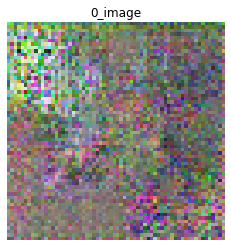

[2/10][322/644] Loss_D: 0.3254 Loss_G: 8.7763
[2/10][644/644] Loss_D: 0.3272 Loss_G: 11.3489



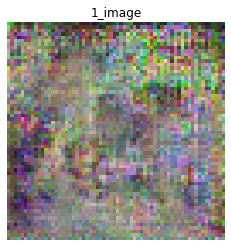

[3/10][322/644] Loss_D: 0.3267 Loss_G: 7.1269
[3/10][644/644] Loss_D: 0.3258 Loss_G: 7.8413



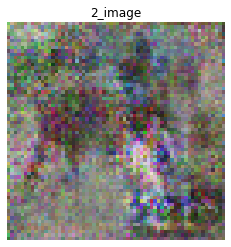

[4/10][322/644] Loss_D: 0.3266 Loss_G: 7.1441
[4/10][644/644] Loss_D: 0.3254 Loss_G: 8.9647



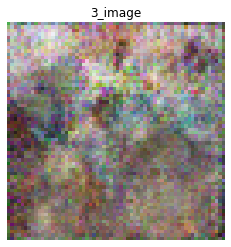

[5/10][322/644] Loss_D: 0.3253 Loss_G: 8.8129


KeyboardInterrupt: 

In [191]:
for epoch in range(n_epochs):
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):

        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real = data.to(device)
        input = Variable(real).to(device)
        target = Variable(torch.ones(input.size()[0])).to(device)
        target = target*real_label
        output = netD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], nz, 1, 1)).to(device)
        fake = netG(noise).to(device)
        target = Variable(torch.zeros(input.size()[0])).to(device)
        output = netD(fake.detach()).to(device)
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real.to(device) + errD_fake.to(device)
        errD.backward()
        doptim.step()
        
        # 2nd Step: Updating the weights of the neural network of the generator
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0])).to(device)
        output = netD(fake).to(device)
        errG = criterion(output, target)
        errG.backward()
        goptim.step()
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, n_epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))

    show_generated_img('%s_image'%epoch)

In [137]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=100
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = (netG(gen_z) + 1)/2
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')



torch.Size([800])

torch.Size([32])